## Imports & Paths

In [15]:
# Import libraries
from google.colab import drive
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
import os
import shutil
import cv2
import random
import dlib
import scipy
from sklearn.preprocessing import normalize

In [3]:
#Paths
drive.mount('/content/drive')
project_dir = "/content/drive/Shareddrives/AGC Labs/Lab 1.2/"
data_dir = project_dir + "data/database/"

Mounted at /content/drive


# Eigenfaces

## Demonstration of dataset

(1866, 4096)
Random Example Images:


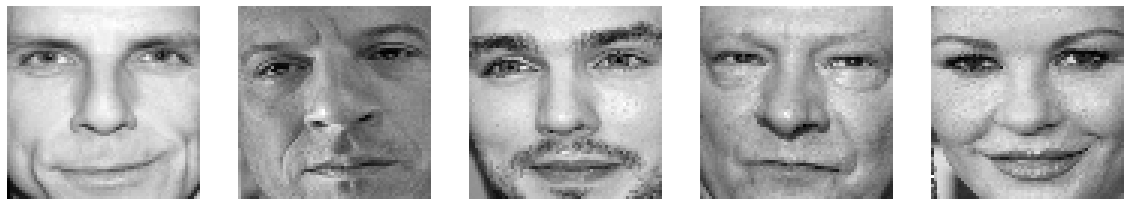

In [6]:
# Load the images
size = 64
images = np.empty((0, size*size))
size_flag = False
for file in os.listdir(data_dir):
    if file.endswith('.jpg'):
        img = cv2.imread(os.path.join(data_dir, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img.shape < (size, size):
          size_flag = True
        img = cv2.resize(img, (size,size))
        img = img.flatten()
        images = np.vstack([images, img])

if size_flag:
  print("WARNING: Not all images are large enough for the selected size. These images will be upscaled!")

print(images.shape)

# Random indexes
example_indexes = []
for i in range(0,5):
  example_indexes.append(random.randint(0, images.shape[0]))

# Random example images
print("Random Example Images:")
plt.figure(figsize=(20, 10))
for i, index in enumerate(example_indexes):
    plt.subplot(1, 5, i+1)
    ex = np.reshape(images[index], (size, size))
    plt.imshow(ex, cmap='gray')
    plt.axis('off')
plt.show()

### Mean faces

Mean Face:


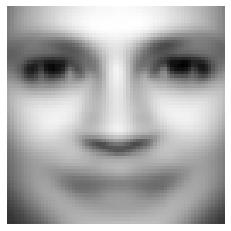

In [7]:
# Mean face
mean_face = np.mean(images, axis=0)
print("Mean Face:")
ex = np.reshape(mean_face, (size, size))
plt.imshow(ex, cmap='gray')
plt.axis('off')
plt.show()

### Normalized faces

Normalized Faces:


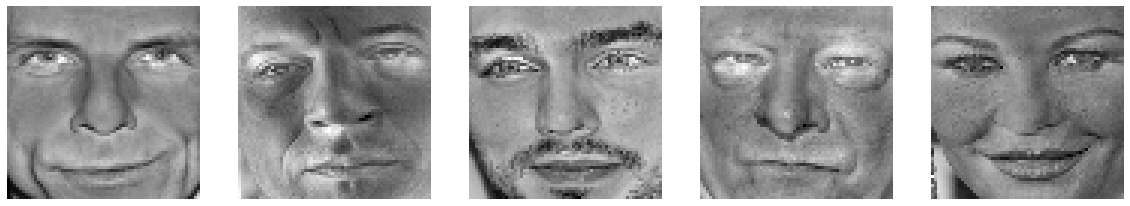

In [8]:
# Normalized faces
normalized_faces = images - mean_face
print("Normalized Faces:")
plt.figure(figsize=(20, 10))
for i, index in enumerate(example_indexes):
    plt.subplot(1, 5, i+1)
    ex = np.reshape(normalized_faces[index], (size, size))
    plt.imshow(ex, cmap='gray')
    plt.axis('off')
plt.show()

## PCA

### Covariance, Eigenvalues & Eigenvectors

Covariance Matrix Shape: (1866, 1866)
Eigenvalues sorted by size: 


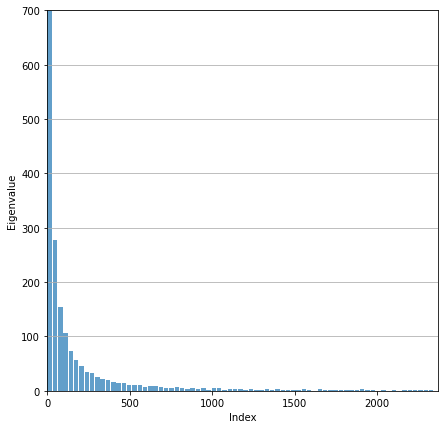

In [9]:
# Covariance matrix
# decision whether to calculate the covariance matrix or the pseudo covariance matrix
if images.shape[0] >= images.shape[1]:
  cov_matrix = np.cov(normalized_faces.T)
else:
  cov_matrix = np.cov(normalized_faces)
print("Covariance Matrix Shape:", cov_matrix.shape)

# Eigenvalues and eigenvectors (already normalized)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)
# Get the index of sorted eigenvalues
eigenvalues_indices = np.argsort(eigenvalues)[::-1]

# plotting the eigenvalues and their significance
print("Eigenvalues sorted by size: ")
plt.figure(figsize=(7, 7))
n, bins, patches = plt.hist(x=np.real(eigenvalues[eigenvalues_indices]), bins='auto', alpha=0.7, rwidth=0.85)                    
plt.grid(axis='y')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
maxX = normalized_faces.shape[0]+500
plt.xlim(0,maxX)
plt.ylim(0,n.max())
plt.show()

### Number of statistically viable principle components

Random Faces:


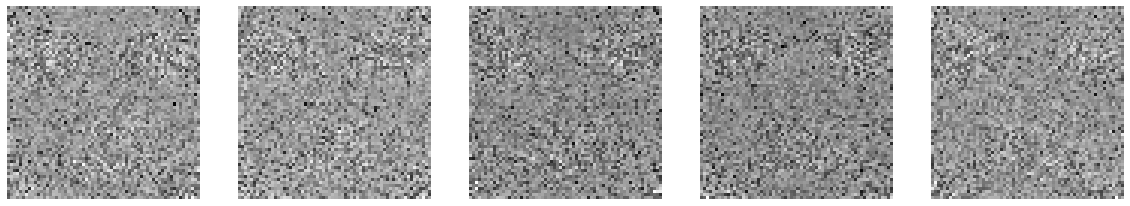

Random Eigenvalues: 


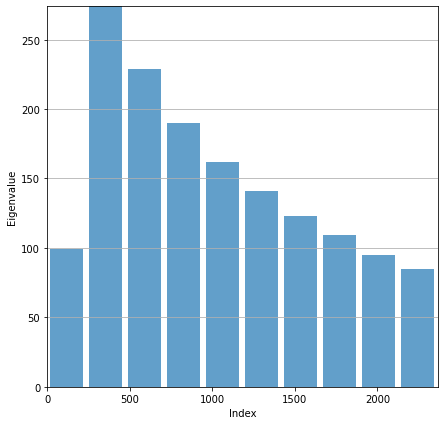

In [10]:
## statistically viable num. of principle components
def shuffle_columns(row):
  np.random.shuffle(row)
  return row

# shuffle the pixels of each face
rand_faces = normalized_faces.copy()
rand_faces = np.apply_along_axis(shuffle_columns, axis=0, arr=rand_faces)

#compute covariance matrix and eigenvalues
if rand_faces.shape[0] >= rand_faces.shape[1]:
  rand_cov_matrix = np.cov(rand_faces.T)
else:
  rand_cov_matrix = np.cov(rand_faces)
rand_eigenvalues, _ = np.linalg.eig(rand_cov_matrix)
rand_eigenvalues = np.real(rand_eigenvalues)
rand_eigenvalues_indices = np.argsort(rand_eigenvalues)[::-1]

# Random faces 
print("Random Faces:")
plt.figure(figsize=(20, 10))
for i, index in enumerate(example_indexes):
    plt.subplot(1, 5, i+1)
    ex = np.reshape(rand_faces[index], (size, size))
    plt.imshow(ex, cmap='gray')
    plt.axis('off')
plt.show()

# plotting the eigenvalues and their significance
print("Random Eigenvalues: ")
plt.figure(figsize=(7, 7))
n, _, _ = plt.hist(x=rand_eigenvalues[rand_eigenvalues_indices], bins='auto', alpha=0.7, rwidth=0.85)                    
plt.grid(axis='y')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
maxX = normalized_faces.shape[0]+500
plt.xlim(0,maxX)
plt.ylim(0,n.max())
plt.show()

In [11]:
# threshold for statistically viable eigenvalues
threshold = rand_eigenvalues[rand_eigenvalues_indices[0]]

def get_first_smaller_index(arr, num):
    for i, x in enumerate(arr):
        if x < num:
            return i - 1
    return len(arr) - 1

# number of principle components that are statistically viable
num_components = get_first_smaller_index(eigenvalues[eigenvalues_indices], threshold)
# create the principle comp. matrix
principal_components = eigenvectors[:, eigenvalues_indices[:num_components]]

### Eigenfaces

Eigenfaces:


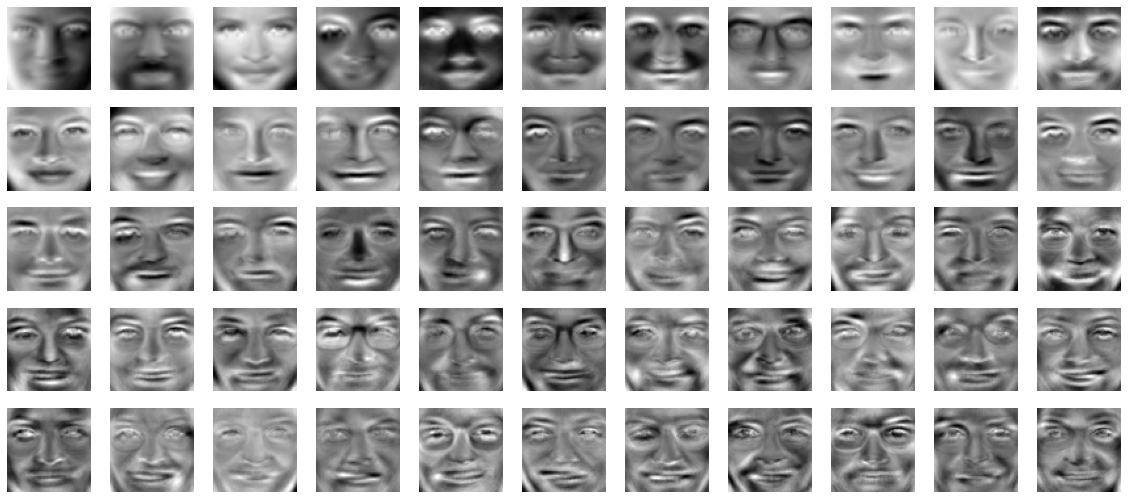

In [12]:
#Eigenfaces
eigenfaces = np.dot(principal_components.T, normalized_faces)
print("Eigenfaces:")
plt.figure(figsize=(20, 20))
for i in range(num_components):
    plt.subplot(np.round(num_components/5), np.round(num_components/5), i+1)
    ex = np.reshape(eigenfaces[i], (size, size))
    plt.imshow(ex, cmap='gray')
    plt.axis('off')
plt.show()

### Reconstruction

Example Images Before and After Reconstruction:


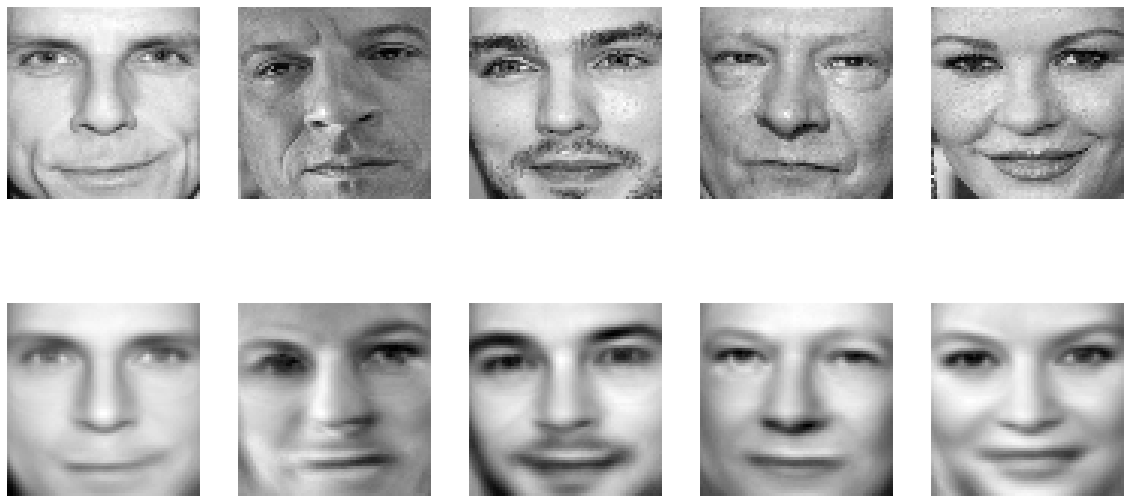

In [13]:
# Perform reconstruction
reconstructed_faces = np.dot(principal_components, eigenfaces) + mean_face

# Showing example images after reconstruction
print("Example Images Before and After Reconstruction:")
plt.figure(figsize=(20, 10))
for i, index in enumerate(example_indexes):
    plt.subplot(2, 5, i+1)
    ex = np.reshape(images[index], (size, size))
    plt.imshow(ex, cmap='gray')
    plt.axis('off')
    plt.subplot(2, 5, 5+i+1)
    ex = np.reshape(reconstructed_faces[index], (size, size))
    plt.imshow(ex, cmap='gray')
    plt.axis('off')
plt.show()

### Reconstruction Error

In [14]:
# Compute the reconstruction error
mse = np.mean((images - reconstructed_faces) ** 2)
print("Mean Reconstruction Error:", mse)


Mean Reconstruction Error: 493.35910110209744


# ASM Landmarks

Examples of landmarks:


<ipython-input-17-271cc4b8efcc>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 5, j+1)


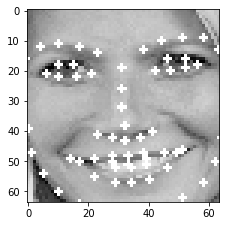

Examples of landmarks:


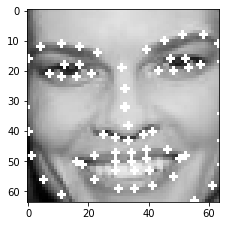

Examples of landmarks:


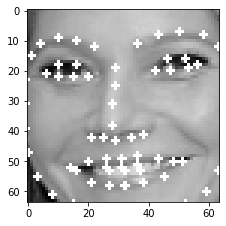

Examples of landmarks:


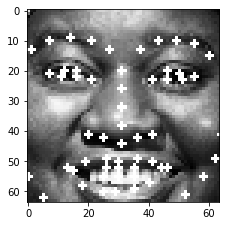

Examples of landmarks:


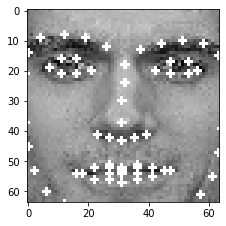

In [17]:
size = 64
num_landmarks = 68
coord = 2
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(project_dir + "data/shape_predictor_68_face_landmarks.dat")
shapes = np.zeros((num_landmarks,coord), dtype="int")
imgs_det = np.empty((0,size*size))
j=0
for file in os.listdir(data_dir):
    if file.endswith('.jpg'):
        img = cv2.imread(os.path.join(data_dir, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (size,size))
        # Detect the face
        faces = detector(img, 1)
        # Detect landmarks for each face
        if len(faces) > 0:
          for face in faces:
            # Get the landmark points
            shape = predictor(img, face)
            # Convert it to the NumPy Array
            shape_np = np.zeros((68, 2), dtype="int")
            for i in range(0, 68):
              shape_np[i] = [shape.part(i).x, shape.part(i).y]
            #Save shapes
            shapes = np.dstack([shapes,shape_np])
            # Display the landmarks
            if 0<=j<5:
              plt.figure(figsize=(20, 10))
              print("Examples of landmarks:")
              for i, [x, y] in enumerate(shape_np):
                plt.subplot(1, 5, j+1)
                # Draw the circle to mark the keypoint 
                cv2.circle(img, [x, y], 1, (255, 0, 0), -1)
              plt.imshow(img,cmap='gray') 
              plt.show()
          j=j+1
          img = img.flatten()  
          imgs_det =np.vstack([imgs_det,img]) 

In [19]:
print("Shapes found:",shapes.shape[2])

Shapes found: 631


#Alignment

In [20]:
reference_shape =  normalize(np.mean(shapes.astype(int), axis=2))
disp = 1
aligned_shapes = np.zeros((num_landmarks,coord), dtype="int")
while disp > 0.5:
  for i in range(0,shapes.shape[2]):
     if np.linalg.norm(shapes[:,:,i]) != 0:
        align_shapes,mtx2,disparity = scipy.spatial.procrustes(reference_shape,shapes[:,:,i]) 
        aligned_shapes = np.dstack([aligned_shapes,align_shapes])
  reference_shape = normalize(np.mean(aligned_shapes, axis=2))
  disp= disparity

# Mean

Mean Face:


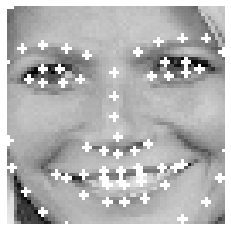

In [21]:
# Mean landmark, image plotted for showing the landmarks
mean_landmark = np.mean(aligned_shapes, axis=2)
print("Mean Face:")
ex = np.reshape(mean_landmark, (num_landmarks, coord))
for i, [x, y] in enumerate(mean_landmark):
    cv2.circle(imgs_det[0], [int(x),int(y)], 1, (255, 0, 0), -1) 
    plt.imshow(imgs_det[0].reshape(size,size) ,cmap='gray')
plt.axis('off')
plt.show()

# Covariance ,eigenvalues and eigenvectors

In [23]:
cov_shapes = np.cov(aligned_shapes.reshape(num_landmarks,coord*aligned_shapes.shape[2]))
print("Covariance shape:",cov_shapes.shape)
eigenvalues, eigenvectors = np.linalg.eig(cov_shapes)
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)
# Get the index of sorted eigenvalues
eigenvalues_indices = np.argsort(eigenvalues)[::-1]

num_components = 10

Covariance shape: (68, 68)


#PCA

In [24]:
# create the principle comp. matrix
principal_components = eigenvectors[:, eigenvalues_indices[:num_components]]
#Compute (x-mean) 
normalized_shapes = np.zeros((num_landmarks,coord), dtype = "int")
for i in range(0,aligned_shapes.shape[2]):
  normalized_shapes = np.dstack([normalized_shapes,aligned_shapes[:,:,i] - mean_landmark])

# Dimensionality reduction

In [25]:
# Find vector b = principal_components.T *(x-mean) 
b = np.dot(principal_components.T,normalized_shapes.reshape(num_landmarks,coord*normalized_shapes.shape[2]))

# Reconstruction

In [26]:
#Obtain reconstruction vector x= x.mean + principal_components*b 
u = normalized_shapes.reshape((num_landmarks,coord*normalized_shapes.shape[2])) + np.dot(principal_components, b)

<ipython-input-27-7d5816c99821>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 5, j+1)


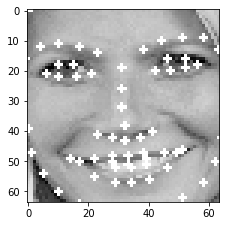

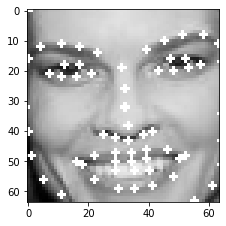

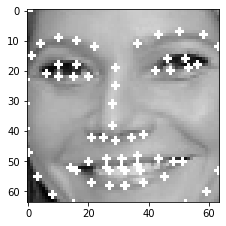

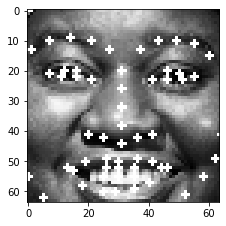

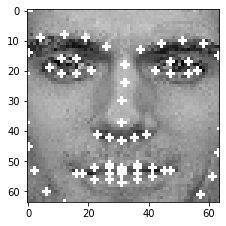

In [27]:
#Plot reconstruction examples
u_1 = u.reshape(num_landmarks,coord,normalized_shapes.shape[2])
for j in range(0,5):
  plt.figure(figsize=(20, 10))
  for i, [x, y] in enumerate(u_1[:,:,j]):
      plt.subplot(1, 5, j+1)
      # Draw the circle to mark the keypoint 
      cv2.circle(imgs_det[j], [int(x),int(y)], 1, (255, 0, 0), -1) 
      plt.imshow(imgs_det[j].reshape(size,size) ,cmap='gray')
      #plt.plot([x,y],'.')
  #plt.axis('off')
  #print(mean_landmark)
  plt.show()

#Statisticaly significant components criteria

<ipython-input-30-a5e1f3f48144>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(212)
<ipython-input-30-a5e1f3f48144>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(212)


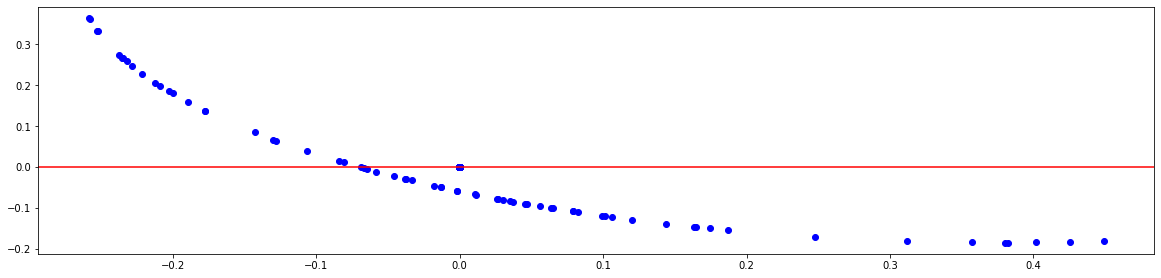

In [30]:
plt.figure(figsize=(20, 10))
for j in range(0,u_1.shape[2]): 
  for i, [x, y] in enumerate(u_1[:,:,j]):
      # Draw the circle to mark the keypoint 
      plt.subplot(212)
      plt.plot(x,y,'bo')
      plt.subplot(212) 
limits = 3*np.sqrt(abs(eigenvalues[num_components]))# Consider only bases in -3*sqrt(eigenvalue)<=b<=-3*sqrt(eigenvalue)       
plt.axhline( limits,color='red')  
plt.show()

In [35]:
mse = np.mean((shapes - u_1[:,:,:shapes.shape[2]]) ** 2)
print("Reconstruction Error:", mse)

Reconstruction Error: 1531.0840936914362
